In [1]:
##----------------------------------------
# Check mesh!
import logging
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import capytaine as cpt
import meshio
from scipy.linalg import block_diag


mesh=meshio.read('Compund44.msh')

mesh

<meshio mesh object>
  Number of points: 3927
  Number of cells:
    vertex: 1
    vertex: 1
    vertex: 1
    vertex: 1
    vertex: 1
    vertex: 1
    vertex: 1
    vertex: 1
    line: 14
    line: 10
    line: 26
    line: 64
    line: 26
    line: 40
    line: 10
    line: 14
    line: 64
    line: 26
    line: 40
    line: 10
    line: 14
    triangle: 2072
    triangle: 1136
    triangle: 2032
    triangle: 1128
  Cell sets: gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:geometrical

In [ ]:
import logging
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import capytaine as cpt
import meshio
from scipy.linalg import block_diag

# Set up logging
logging.basicConfig(level=logging.INFO,
                    format="%(levelname)s:\t%(message)s")

# Load in diamond mesh via gmsh -

#mesh=meshio.read('Diamond333.msh')
mesh=meshio.read('Diamond7Sept.msh')
body = cpt.FloatingBody.from_meshio(mesh, name = "Diamond")
body.keep_immersed_part()

# Solve with direct Solver:

body .translate_z(-5e-3)

body.add_all_rigid_body_dofs()
#body.add_translation_dof(name="Heave")

body.center_of_mass = (0, 0, -4)

# Add hydrostatic data

m = 1040838

Ixx = 3.859E7
Ixy = -20
Ixz = 10
Iyy = 9.842E+06
Iyz = 5.553
Izz = 9.842E+06

I = np.array([[Ixx,Ixy,Ixz],
              [Ixy,Iyy,Iyz],
              [Ixz,Iyz,Izz]])

M = block_diag(m,m,m,I)
#M = block_diag(m)
body.mass = body.add_dofs_labels_to_matrix(M)


K33 = 1.1656E+06
K34 = -3.2159E+00
K35 = -2.7730E+00
K44 = 2.6603E+07
K45 = 0.0000E+00
K55 = 2.6603E+07

StiffnessMatrix = np.array([[K33,K34,K35],[K34,K44,K45],[K35,K45,K55]])
kHS = block_diag(0,0,StiffnessMatrix,0)
#kHS = block_diag(K33)

body.hydrostatic_stiffness = body.add_dofs_labels_to_matrix(kHS)

test_matrix = xr.Dataset(coords={
    'omega': np.linspace(0.35, 1.05,8),
    'radiating_dof': list(body.dofs.keys()),
    'wave_direction': [0],
    'rho': 1000})

Di = cpt.BEMSolver(green_function=cpt.XieDelhommeau()).fill_dataset(test_matrix, [body],
                                                                   hydrostatics=True,
                                                                    mesh=True,
                                                                    wavelength=True,
                                                                    wavenumber=True)

INFO:	Stored 25472 triangle faces as quadrilaterals
INFO:	New floating body: Diamond.
INFO:	Clipping Diamond with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:	Clipping Diamond_mesh by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:	Solve DiffractionProblem(body=Diamond, omega=0.350, depth=inf, wave_direction=0.000).


INFO:	Compute RAO.


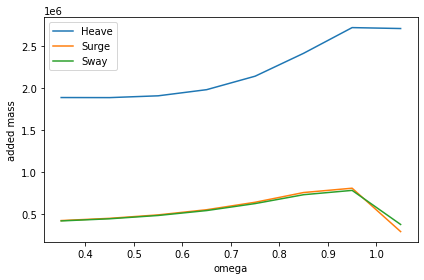

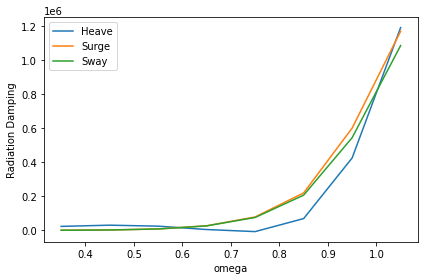

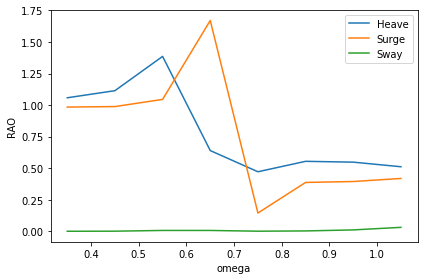

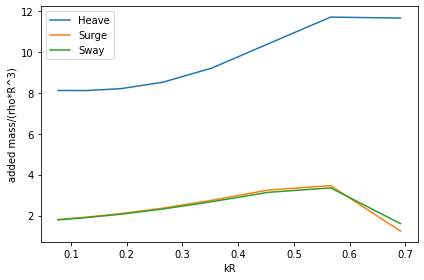

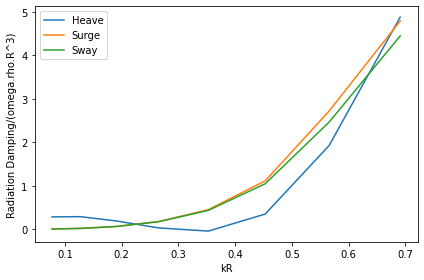

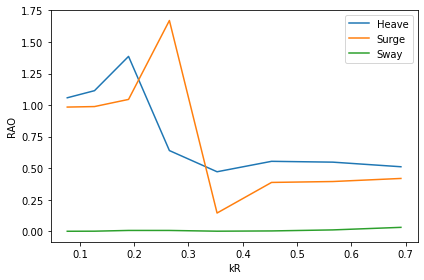

In [53]:
import matplotlib.pyplot as plt

dofs = ["Heave","Surge","Sway"]
#dofs = ["Heave"]

# Constant for Non-Dom
DiR = 6.15
DiC = (1000*DiR*DiR*DiR)

# Added Mass vs. omega
plt.figure()
for dof in dofs:
    plt.plot(
        Di['omega'],
        Di['added_mass'].sel(radiating_dof=dof, influenced_dof=dof),
        label=dof)
plt.xlabel('omega')
plt.ylabel('added mass')
plt.legend()
plt.tight_layout()


# Radiation damping vs. omega
plt.figure()
for dof in dofs:
    plt.plot(
        Di['omega'],
        Di['radiation_damping'].sel(radiating_dof=dof, influenced_dof=dof),
        label=dof)  
plt.xlabel('omega')
plt.ylabel('Radiation Damping')
plt.legend()
plt.tight_layout()


# Compute RAO
#d = 7200000
d = 0
#dampingMatrix = np.transpose(np.repeat(d,140))
dampingMatrix = d
Di['RAO'] = cpt.post_pro.rao(Di,dissipation=dampingMatrix)

# RAO vs. omega
plt.figure()
for dof in dofs:
    plt.plot(
        Di['omega'],
        np.abs(Di['RAO'].sel(radiating_dof=dof)),
        label=dof)
plt.xlabel('omega')
plt.ylabel('RAO')
plt.legend()
plt.tight_layout()
plt.show()




# Added mass vs. kR
plt.figure()
for dof in dofs:
    plt.plot(
        Di['wavenumber']*DiR,
        Di['added_mass'].sel(radiating_dof=dof, influenced_dof=dof)/DiC,
        label=dof)
plt.xlabel('kR')
plt.ylabel('added mass/(rho*R^3)')
plt.legend()
plt.tight_layout()

# radiation damping vs. kR
plt.figure()
for dof in dofs:
    plt.plot(
        Di['wavenumber']*DiR,
        Di['radiation_damping'].sel(radiating_dof=dof, influenced_dof=dof)/(Di['omega']*DiC),
        label=dof)
plt.xlabel('kR')
plt.ylabel('Radiation Damping/(omega.rho.R^3)')
plt.legend()
plt.tight_layout()

# RAO vs. kR
plt.figure()
for dof in dofs:
    plt.plot(
        Di['wavenumber']*DiR,
        np.abs(Di['RAO'].sel(radiating_dof=dof)),
        label=dof)
plt.xlabel('kR')
plt.ylabel('RAO')
plt.legend()
plt.tight_layout()
plt.show()

plt.show()

In [11]:
##----------------------------------------------------------------

In [3]:
import logging
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import capytaine as cpt
import meshio
from scipy.linalg import block_diag

# Set up logging
logging.basicConfig(level=logging.INFO,
                    format="%(levelname)s:\t%(message)s")


# Load in diamond mesh via gmsh -

mesh=meshio.read('compund11Sept.msh')
body = cpt.FloatingBody.from_meshio(mesh, name = "compund")

# Setup Body
body .translate_z(-5e-2)
body.center_of_mass = (0, 0, -6)
body.add_all_rigid_body_dofs()

# Add inertial from meshmagick
m = 1728000
Ixx = 1.461E+08
Ixy = -20
Ixz = 10
Iyy = 1.542E+08
Iyz = 5.553
Izz = 7.601E+07
I = np.array([[Ixx,Ixy,Ixz],
              [Ixy,Iyy,Iyz],
              [Ixz,Iyz,Izz]])

M = block_diag(m,m,m,I)
body.mass = body.add_dofs_labels_to_matrix(M)

# Add hydrodynamic data from meshmagick
K33 = 1.8510E+06
K34 = 1.7776E+05
K35 = 1.3532E+06
K44 = 2.3468E+07
K45 = 1.0829E+05
K55 = 2.4441E+07

StiffnessMatrix = np.array([[K33,K34,K35],[K34,K44,K45],[K35,K45,K55]])
kHS = block_diag(0,0,StiffnessMatrix,0)


body.hydrostatic_stiffness = body.add_dofs_labels_to_matrix(kHS)

# Setup Problem
test_matrix = xr.Dataset(coords={
    'omega': np.linspace(0.35,1.05,10),
    'radiating_dof': list(body.dofs.keys()),
    'wave_direction': [0],
    'rho': 1000
})
# Solve Problem
Cm = cpt.BEMSolver(green_function=cpt.XieDelhommeau()).fill_dataset(test_matrix, [body],
                                                                   hydrostatics=True,
                                                                    mesh=True,
                                                                    wavelength=True,
                                                                    wavenumber=True)

INFO:	Stored 4720 triangle faces as quadrilaterals
INFO:	New floating body: compund.
INFO:	The rotation dof Roll has been initialized around the point: compund.center_of_mass = (0, 0, -6)
INFO:	The rotation dof Pitch has been initialized around the point: compund.center_of_mass = (0, 0, -6)
INFO:	The rotation dof Yaw has been initialized around the point: compund.center_of_mass = (0, 0, -6)
INFO:	Solve DiffractionProblem(body=compund, omega=0.350, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationProblem(body=compund, omega=0.350, depth=inf, radiating_dof=Surge).


KeyboardInterrupt: 

INFO:	Compute RAO.


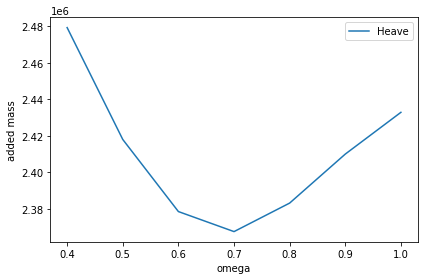

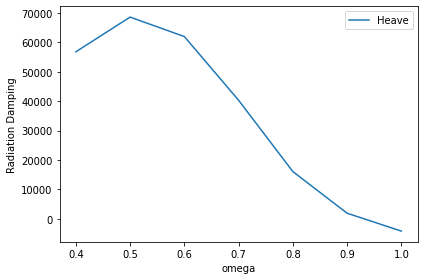

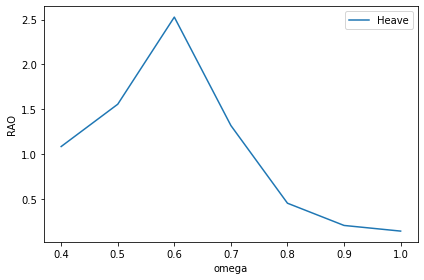

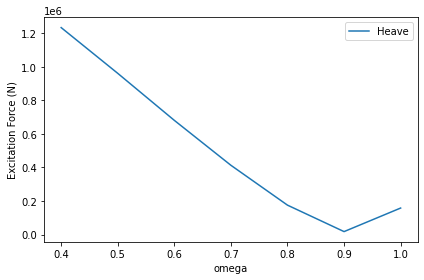

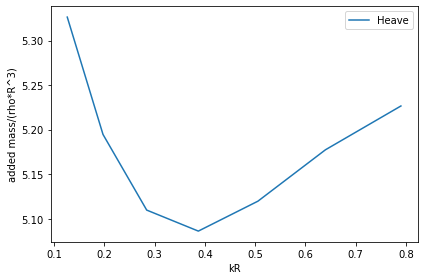

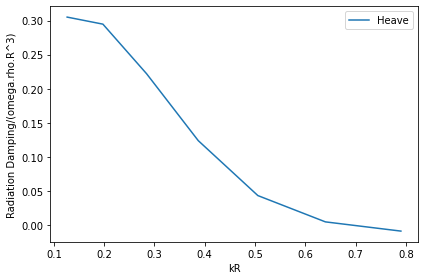

In [40]:
import matplotlib.pyplot as plt

#dofs = ["Heave","Surge","Sway"]
dofs = ["Heave"]

# Constant for Non-Dom
CmR = 7.75
CmC = (1000*CmR*CmR*CmR)
CmR
 


# Added Mass vs. omega
plt.figure()
for dof in dofs:
    plt.plot(
        Cm['omega'],
        Cm['added_mass'].sel(radiating_dof=dof, influenced_dof=dof),
        label=dof)
plt.xlabel('omega')
plt.ylabel('added mass')
plt.legend()
plt.tight_layout()


# Radiation damping vs. omega
plt.figure()
for dof in dofs:
    plt.plot(
        Cm['omega'],
        Cm['radiation_damping'].sel(radiating_dof=dof, influenced_dof=dof),
        label=dof)  
plt.xlabel('omega')
plt.ylabel('Radiation Damping')
plt.legend()
plt.tight_layout()




# Compute RAO
d = 0
d= 720000
#dampingMatrix = np.transpose(np.repeat(d,13))
dampingMatrix = d
Cm['RAO'] = cpt.post_pro.rao(Cm,dissipation = d)

# RAO vs. omega
plt.figure()
for dof in dofs:
    plt.plot(
        Cm['omega'],
        np.abs(Cm['RAO'].sel(radiating_dof=dof)),
        label =dof)
plt.xlabel('omega')
plt.ylabel('RAO')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for dof in dofs:
    plt.plot(
        Cm['omega'],
        np.abs(Cm['excitation_force'].sel(influenced_dof=dof)),
        label=dof)  
plt.xlabel('omega')
plt.ylabel('Excitation Force (N)')
plt.legend()
plt.tight_layout()


# Added mass vs. kR
plt.figure()
for dof in dofs:
    plt.plot(
        Cm['wavenumber']*CmR,
        Cm['added_mass'].sel(radiating_dof=dof, influenced_dof=dof)/CmC,
        label=dof)
plt.xlabel('kR')
plt.ylabel('added mass/(rho*R^3)')
plt.legend()
plt.tight_layout()

# radiation damping vs. kR
plt.figure()
for dof in dofs:
    plt.plot(
        Cm['wavenumber']*CmR,
        Cm['radiation_damping'].sel(radiating_dof=dof, influenced_dof=dof)/(Cm['omega']*CmC),
        label=dof)
plt.xlabel('kR')
plt.ylabel('Radiation Damping/(omega.rho.R^3)')
plt.legend()
plt.tight_layout()

plt.show()

In [3]:
dof = ['Heave']
min(Cm['radiation_damping'].sel(radiating_dof=dof, influenced_dof=dof))

NameError: name 'Cm' is not defined

INFO:	Compute RAO.
INFO:	Compute RAO.
INFO:	Compute RAO.
INFO:	Compute RAO.
INFO:	Compute RAO.
INFO:	Compute RAO.
INFO:	Compute RAO.
INFO:	Compute RAO.
INFO:	Compute RAO.
INFO:	Compute RAO.


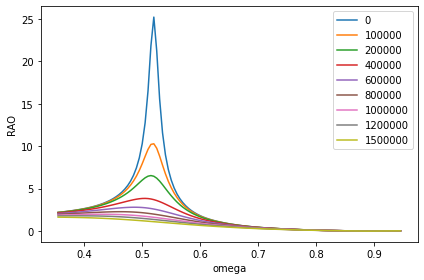

INFO:	Compute RAO.
INFO:	Compute RAO.
INFO:	Compute RAO.
INFO:	Compute RAO.
INFO:	Compute RAO.
INFO:	Compute RAO.
INFO:	Compute RAO.
INFO:	Compute RAO.
INFO:	Compute RAO.


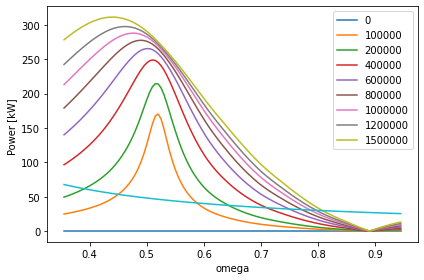

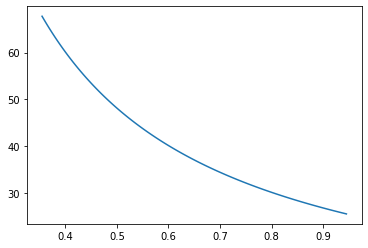

In [59]:
# Compute RAO
d = 0
d= 720000
dampingMatrix = np.transpose(np.repeat(d,119))
Cm['RAO'] = cpt.post_pro.rao(Cm,dissipation=dampingMatrix)
d = [0,100000,200000,400000,600000,800000,1000000,1200000,1500000]
# RAO vs. omega
plt.figure()
for dof in dofs:
    for damps in d:
        dampingMatrix = damps
        Cm['RAO'] = cpt.post_pro.rao(Cm,dissipation=dampingMatrix)
        plt.plot(
            Cm['omega'],
            np.abs(Cm['RAO'].sel(radiating_dof=dof)),
            label=damps)
plt.xlabel('omega')
plt.ylabel('RAO')
plt.legend()
plt.tight_layout()
plt.show()
WavePower = 0.25*1000*9.81*(Cm['omega']/Cm['wavenumber'])/1000
# Power graph
plt.figure()
for dof in dofs:
    for damps in d:
        dampingMatrix = damps
        Cm['RAO'] = cpt.post_pro.rao(Cm,dissipation=dampingMatrix)
        power = (1/np.pi)*np.abs(Cm['RAO'].sel(radiating_dof=dof))*Cm['omega']*damps/1000
        plt.plot(
            Cm['omega'],
            power,
            label=damps)
        
plt.plot(Cm['omega'],WavePower)
plt.xlabel('omega')
plt.ylabel('Power [kW] ')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(Cm['omega'],WavePower)


In [11]:
# Cylinder

import logging
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import capytaine as cpt
import meshio
from scipy.linalg import block_diag

# Set up logging
logging.basicConfig(level=logging.INFO,
                    format="%(levelname)s:\t%(message)s")



# Load in diamond mesh via gmsh -

mesh=meshio.read('Cylinder45.msh')
body = cpt.FloatingBody.from_meshio(mesh, name = "Cylinder")
body.keep_immersed_part()

# Solve with direct Solver:

body .translate_z(-5e-2)

body.add_all_rigid_body_dofs()
#body.add_translation_dof(name="Heave")

# Add hydrostatic data

m = 10.844938E6
Ixx = 1.336E9
Ixy = -19.40
Ixz = 113.5
Iyy = 1.336E9
Iyz = 5.553
Izz = 1.101E9

I = np.array([[Ixx,Ixy,Ixz],
              [Ixy,Iyy,Iyz],
              [Ixz,Iyz,Izz]])

M = block_diag(m,m,m,I)
#M = [[m]]
body.mass = body.add_dofs_labels_to_matrix(M)

K33 = 6.2582E+06
K34 = 1.6148E+01
K35 = 1.6882E+00
K44 = -1.6105E+07
K45 = -1.3335E+01
K55 = -1.6105E+08

StiffnessMatrix = np.array([[K33,K34,K35],[K34,K44,K45],[K35,K45,K55]])
kHS = block_diag(0,0,StiffnessMatrix,0)
#kHS = [[K33]]


body.hydrostatic_stiffness = body.add_dofs_labels_to_matrix(kHS)

test_matrix = xr.Dataset(coords={
    'omega': np.linspace(0.355, 1.05,140),
    'radiating_dof': list(body.dofs.keys()),
    'wave_direction': [0],
    'rho': 1000
})

Cy = cpt.BEMSolver(green_function=cpt.XieDelhommeau()).fill_dataset(test_matrix, [body],
                                                                   hydrostatics=True,
                                                                    mesh=True,
                                                                    wavelength=True,
                                                                    wavenumber=True)

INFO:	Stored 6688 triangle faces as quadrilaterals
INFO:	New floating body: Cylinder.
INFO:	Clipping Cylinder with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:	Clipping Cylinder_mesh by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:	Solve DiffractionProblem(body=Cylinder, omega=0.355, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.355, depth=inf, radiating_dof=Surge).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.355, depth=inf, radiating_dof=Sway).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.355, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.355, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.355, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.355, depth=inf, radiating_dof=Yaw).
INFO:	Solve DiffractionProblem(body=Cylinder, omega=0.360, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationP

INFO:	Solve RadiationProblem(body=Cylinder, omega=0.415, depth=inf, radiating_dof=Sway).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.415, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.415, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.415, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.415, depth=inf, radiating_dof=Yaw).
INFO:	Solve DiffractionProblem(body=Cylinder, omega=0.420, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.420, depth=inf, radiating_dof=Surge).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.420, depth=inf, radiating_dof=Sway).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.420, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.420, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.420, depth=inf, radiating_dof=Pitch).
INFO:	Solve R

INFO:	Solve RadiationProblem(body=Cylinder, omega=0.480, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.480, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.480, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.480, depth=inf, radiating_dof=Yaw).
INFO:	Solve DiffractionProblem(body=Cylinder, omega=0.485, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.485, depth=inf, radiating_dof=Surge).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.485, depth=inf, radiating_dof=Sway).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.485, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.485, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.485, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.485, depth=inf, radiating_dof=Yaw).
INFO:	Solve Di

INFO:	Solve RadiationProblem(body=Cylinder, omega=0.545, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.545, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.545, depth=inf, radiating_dof=Yaw).
INFO:	Solve DiffractionProblem(body=Cylinder, omega=0.550, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.550, depth=inf, radiating_dof=Surge).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.550, depth=inf, radiating_dof=Sway).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.550, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.550, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.550, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.550, depth=inf, radiating_dof=Yaw).
INFO:	Solve DiffractionProblem(body=Cylinder, omega=0.555, depth=inf, wave_direction=0.000).
INFO:	Solve

INFO:	Solve RadiationProblem(body=Cylinder, omega=0.610, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.610, depth=inf, radiating_dof=Yaw).
INFO:	Solve DiffractionProblem(body=Cylinder, omega=0.615, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.615, depth=inf, radiating_dof=Surge).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.615, depth=inf, radiating_dof=Sway).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.615, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.615, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.615, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.615, depth=inf, radiating_dof=Yaw).
INFO:	Solve DiffractionProblem(body=Cylinder, omega=0.620, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.620, depth=inf, radiating_dof=Surge).
INFO:	Solv

INFO:	Solve RadiationProblem(body=Cylinder, omega=0.675, depth=inf, radiating_dof=Yaw).
INFO:	Solve DiffractionProblem(body=Cylinder, omega=0.680, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.680, depth=inf, radiating_dof=Surge).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.680, depth=inf, radiating_dof=Sway).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.680, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.680, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.680, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.680, depth=inf, radiating_dof=Yaw).
INFO:	Solve DiffractionProblem(body=Cylinder, omega=0.685, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.685, depth=inf, radiating_dof=Surge).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.685, depth=inf, radiating_dof=Sway).
INFO:	Solve

INFO:	Solve DiffractionProblem(body=Cylinder, omega=0.745, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.745, depth=inf, radiating_dof=Surge).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.745, depth=inf, radiating_dof=Sway).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.745, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.745, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.745, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.745, depth=inf, radiating_dof=Yaw).
INFO:	Solve DiffractionProblem(body=Cylinder, omega=0.750, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.750, depth=inf, radiating_dof=Surge).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.750, depth=inf, radiating_dof=Sway).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.750, depth=inf, radiating_dof=Heave).
INFO:	Sol

INFO:	Solve RadiationProblem(body=Cylinder, omega=0.810, depth=inf, radiating_dof=Surge).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.810, depth=inf, radiating_dof=Sway).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.810, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.810, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.810, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.810, depth=inf, radiating_dof=Yaw).
INFO:	Solve DiffractionProblem(body=Cylinder, omega=0.815, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.815, depth=inf, radiating_dof=Surge).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.815, depth=inf, radiating_dof=Sway).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.815, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.815, depth=inf, radiating_dof=Roll).
INFO:	Solve R

INFO:	Solve RadiationProblem(body=Cylinder, omega=0.875, depth=inf, radiating_dof=Sway).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.875, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.875, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.875, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.875, depth=inf, radiating_dof=Yaw).
INFO:	Solve DiffractionProblem(body=Cylinder, omega=0.880, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.880, depth=inf, radiating_dof=Surge).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.880, depth=inf, radiating_dof=Sway).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.880, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.880, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.880, depth=inf, radiating_dof=Pitch).
INFO:	Solve R

INFO:	Solve RadiationProblem(body=Cylinder, omega=0.940, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.940, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.940, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.940, depth=inf, radiating_dof=Yaw).
INFO:	Solve DiffractionProblem(body=Cylinder, omega=0.945, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.945, depth=inf, radiating_dof=Surge).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.945, depth=inf, radiating_dof=Sway).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.945, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.945, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.945, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=0.945, depth=inf, radiating_dof=Yaw).
INFO:	Solve Di

INFO:	Solve RadiationProblem(body=Cylinder, omega=1.005, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=1.005, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=1.005, depth=inf, radiating_dof=Yaw).
INFO:	Solve DiffractionProblem(body=Cylinder, omega=1.010, depth=inf, wave_direction=0.000).
INFO:	Solve RadiationProblem(body=Cylinder, omega=1.010, depth=inf, radiating_dof=Surge).
INFO:	Solve RadiationProblem(body=Cylinder, omega=1.010, depth=inf, radiating_dof=Sway).
INFO:	Solve RadiationProblem(body=Cylinder, omega=1.010, depth=inf, radiating_dof=Heave).
INFO:	Solve RadiationProblem(body=Cylinder, omega=1.010, depth=inf, radiating_dof=Roll).
INFO:	Solve RadiationProblem(body=Cylinder, omega=1.010, depth=inf, radiating_dof=Pitch).
INFO:	Solve RadiationProblem(body=Cylinder, omega=1.010, depth=inf, radiating_dof=Yaw).
INFO:	Solve DiffractionProblem(body=Cylinder, omega=1.015, depth=inf, wave_direction=0.000).
INFO:	Solve

INFO:	Compute RAO.


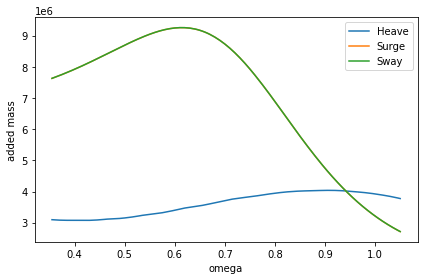

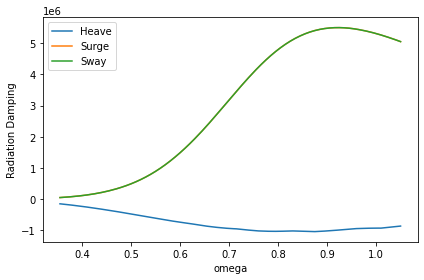

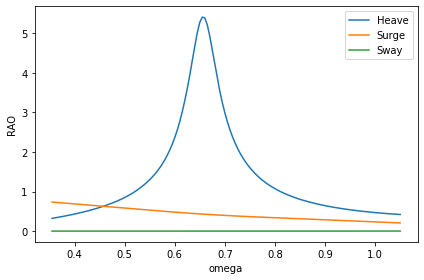

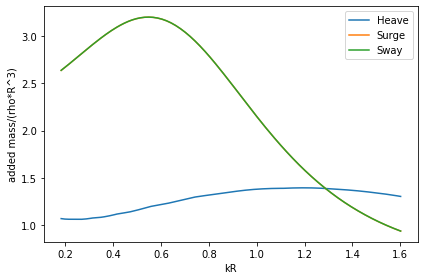

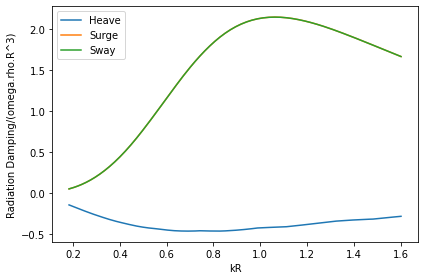

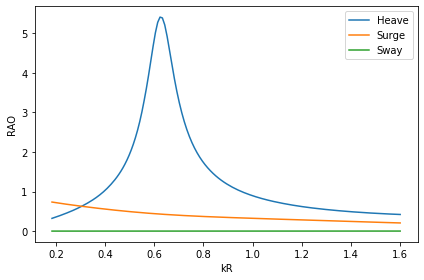

In [12]:
import matplotlib.pyplot as plt

dofs = ["Heave","Surge","Sway"]
#dofs = ["Heave"]

# Constant for Non-Dom
CyR = 14.25
CyC = (1000*CyR*CyR*CyR)


# Added Mass vs. omega
plt.figure()
for dof in dofs:
    plt.plot(
        Cy['omega'],
        Cy['added_mass'].sel(radiating_dof=dof, influenced_dof=dof),
        label=dof)
plt.xlabel('omega')
plt.ylabel('added mass')
plt.legend()
plt.tight_layout()


# Radiation damping vs. omega
plt.figure()
for dof in dofs:
    plt.plot(
        Cy['omega'],
        Cy['radiation_damping'].sel(radiating_dof=dof, influenced_dof=dof),
        label=dof)  
plt.xlabel('omega')
plt.ylabel('Radiation Damping')
plt.legend()
plt.tight_layout()


# Compute RAO
Cy['RAO'] = cpt.post_pro.rao(Cy)

# RAO vs. omega
plt.figure()
for dof in dofs:
    plt.plot(
        Cy['omega'],
        np.abs(Cy['RAO'].sel(radiating_dof=dof)),
        label=dof)
plt.xlabel('omega')
plt.ylabel('RAO')
plt.legend()
plt.tight_layout()
plt.show()




# Added mass vs. kR
plt.figure()
for dof in dofs:
    plt.plot(
        Cy['wavenumber']*CyR,
        Cy['added_mass'].sel(radiating_dof=dof, influenced_dof=dof)/CyC,
        label=dof)
plt.xlabel('kR')
plt.ylabel('added mass/(rho*R^3)')
plt.legend()
plt.tight_layout()

# radiation damping vs. kR
plt.figure()
for dof in dofs:
    plt.plot(
        Cy['wavenumber']*CyR,
        Cy['radiation_damping'].sel(radiating_dof=dof, influenced_dof=dof)/(Cy['omega']*CyC),
        label=dof)
plt.xlabel('kR')
plt.ylabel('Radiation Damping/(omega.rho.R^3)')
plt.legend()
plt.tight_layout()

# RAO vs. kR
plt.figure()
for dof in dofs:
    plt.plot(
        Cy['wavenumber']*CyR,
        np.abs(Cy['RAO'].sel(radiating_dof=dof)),
        label=dof)
plt.xlabel('kR')
plt.ylabel('RAO')
plt.legend()
plt.tight_layout()
plt.show()

plt.show()

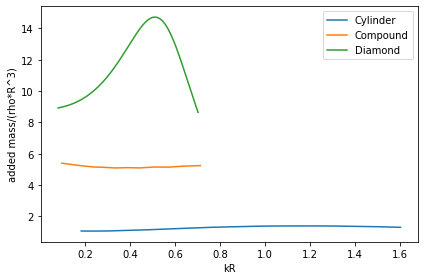

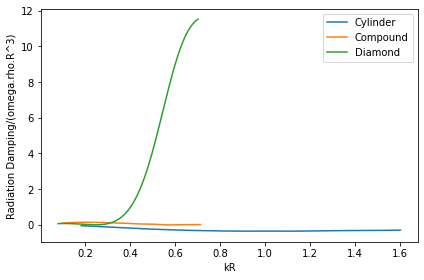

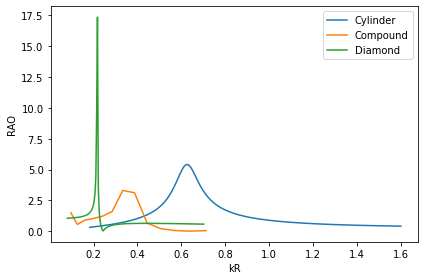

In [13]:
# All Together Now!

# Added mass vs. kR
import matplotlib.pyplot as plt

CyR = 14.25
CmR = 7.75
DiR = 6.25

CyC = 1000*CyR*CyR*CyR
CmC = 1000*CmR*CmR*CmR
DiC = 1000*DiR*DiR*DiR

dofs = ["Heave"]

plt.figure()
for dof in dofs:
    plt.plot(Cy['wavenumber']*CyR,Cy['added_mass'].sel(radiating_dof=dof, influenced_dof=dof)/CyC,
        label='Cylinder')
    plt.plot(Cm['wavenumber']*CmR,Cm['added_mass'].sel(radiating_dof=dof, influenced_dof=dof)/CmC,
            label='Compound')
    plt.plot(Di['wavenumber']*DiR,Di['added_mass'].sel(radiating_dof=dof, influenced_dof=dof)/DiC,
        label='Diamond')
    
plt.xlabel('kR')
plt.ylabel('added mass/(rho*R^3)')
plt.legend()
plt.tight_layout()


plt.figure()    
for dof in ["Heave"]:
    plt.plot(Cy['wavenumber']*CyR,Cy['radiation_damping'].sel(radiating_dof=dof, influenced_dof=dof)/CyC,
        label='Cylinder')
    plt.plot(Cm['wavenumber']*CmR,Cm['radiation_damping'].sel(radiating_dof=dof, influenced_dof=dof)/CmC,
            label='Compound')
    plt.plot(Di['wavenumber']*DiR,Di['radiation_damping'].sel(radiating_dof=dof, influenced_dof=dof)/DiC,
        label='Diamond')
plt.xlabel('kR')
plt.ylabel('Radiation Damping/(omega.rho.R^3)')
plt.legend()
plt.tight_layout()


# RAO vs. kR
plt.figure()
for dof in dofs:
    plt.plot(Cy['wavenumber']*CyR,np.abs(Cy['RAO'].sel(radiating_dof=dof)),label='Cylinder')
    plt.plot(Cm['wavenumber']*CmR,np.abs(Cm['RAO'].sel(radiating_dof=dof)),label='Compound')
    plt.plot(Di['wavenumber']*DiR,np.abs(Di['RAO'].sel(radiating_dof=dof)),label='Diamond')

plt.xlabel('kR')
plt.ylabel('RAO')
plt.legend()
plt.tight_layout()
plt.show()

plt.show()

<xarray.DataArray 'excitation_force' (omega: 119, wave_direction: 1, influenced_dof: 6)>
array([[[2.06744798e+06, 1.94147019e+02, 4.32604655e+06, 8.95354604e+02,
         1.25990091e+07, 8.25467891e+02]],

       [[2.12220498e+06, 1.99302658e+02, 4.28161615e+06, 9.14678184e+02,
         1.29328120e+07, 8.46173287e+02]],

       [[2.17751461e+06, 2.04588785e+02, 4.23704996e+06, 9.33805401e+02,
         1.32699874e+07, 8.67025925e+02]],

       [[2.23336542e+06, 2.09843048e+02, 4.19235535e+06, 9.52547372e+02,
         1.36104782e+07, 8.88004741e+02]],

       [[2.28975999e+06, 2.15210019e+02, 4.14753962e+06, 9.71255495e+02,
         1.39540749e+07, 9.09109862e+02]],

       [[2.34669294e+06, 2.20599260e+02, 4.10261219e+06, 9.90067106e+02,
         1.43007535e+07, 9.30358755e+02]],

       [[2.40414781e+06, 2.26101381e+02, 4.05758398e+06, 1.00881699e+03,
         1.46504815e+07, 9.51717886e+02]],
...
       [[5.18550999e+06, 2.30391653e+02, 6.25686507e+05, 2.16619475e+03,
         2.92682772e+07, 2.58573425e+03]],

       [[5.14424804e+06, 2.22764082e+02, 6.11045270e+05, 2.18828361e+03,
         2.89854277e+07, 2.61166894e+03]],

       [[5.10262737e+06, 2.15027213e+02, 5.96689110e+05, 2.23024616e+03,
         2.87008152e+07, 2.63768820e+03]],

       [[5.06069078e+06, 2.06962496e+02, 5.82619745e+05, 2.21273341e+03,
         2.84147617e+07, 2.66408120e+03]],

       [[5.01847041e+06, 2.00573614e+02, 5.68846298e+05, 2.23177645e+03,
         2.81274232e+07, 2.69051466e+03]],

       [[4.97600878e+06, 1.93729686e+02, 5.55347131e+05, 2.26985620e+03,
         2.78390806e+07, 2.71800270e+03]],

       [[4.93332760e+06, 1.84867899e+02, 5.42124427e+05, 2.24813047e+03,
         2.75498307e+07, 2.74548385e+03]]])
Coordinates:
    g                  float64 9.81
    rho                int64 1000
    body_name          <U8 'Cylinder'
    water_depth        float64 inf
  * omega              (omega) float64 0.355 0.36 0.365 ... 0.935 0.94 0.945
  * influenced_dof     (influenced_dof) object 'Surge' 'Sway' ... 'Pitch' 'Yaw'
  * wave_direction     (wave_direction) float64 0.0
    wavenumber         (omega) float64 0.01285 0.01321 ... 0.09007 0.09103
    wavelength         (omega) float64 489.1 475.6 462.7 ... 70.51 69.76 69.02
    nb_faces           int64 5104
    quadrature_method  <U4 'None'

In [26]:
# Added mass vs. kR
plt.figure()

CyR = 14.25
CmR = 7.75
DiR = 6.25

CyC = 1000*CyR*CyR*CyR
CmC = 1000*CmR*CmR*CmR
DiC = 1000*DiR*DiR*DiR


for dof in ["Heave"]:
    plt.plot(Cy['wavenumber']*14.5,Cy['added_mass'].sel(radiating_dof=dof, influenced_dof=dof)/CyC,
        label='Cylinder')
    plt.plot(Cm['wavenumber']*10,Cm['added_mass'].sel(radiating_dof=dof, influenced_dof=dof)/CmC,
            label='Compound')
    plt.plot(Di['wavenumber']*6.25,Di['added_mass'].sel(radiating_dof=dof, influenced_dof=dof)/DiC,
        label='Diamond')
    
plt.xlabel('kR')
plt.ylabel('added mass/(rho*R^3)')
plt.legend()
plt.tight_layout()

# radiation damping vs. kR
plt.figure()    
for dof in ["Heave"]:
    plt.plot(Cy['wavenumber']*CyR,Cy['radiation_damping'].sel(radiating_dof=dof, influenced_dof=dof)/CyC,
        label='Cylinder')
    plt.plot(Cm['wavenumber']*CmR,Cm['radiation_damping'].sel(radiating_dof=dof, influenced_dof=dof)/CmC,
            label='Compound')
    plt.plot(Di['wavenumber']*DiR,Di['radiation_damping'].sel(radiating_dof=dof, influenced_dof=dof)/DiC,
        label='Diamond')
plt.xlabel('kR')
plt.ylabel('Radiation Damping/(omega.rho.R^3)')
plt.legend()
plt.tight_layout()

# RAO vs. omega
plt.figure()
for dof in ["Heave"]:
    plt.plot(Cy['omega'],np.abs(Cy['RAO'].sel(radiating_dof=dof)),label='Cylinder')
    plt.plot(Cm['omega'],np.abs(Cm['RAO'].sel(radiating_dof=dof)),label='Compound')
    plt.plot(Di['omega'],np.abs(Di['RAO'].sel(radiating_dof=dof)),label='Diamond')

plt.xlabel('omega')
plt.ylabel('RAO')
plt.legend()
plt.tight_layout()


plt.show()

NameError: name 'Cy' is not defined

<Figure size 432x288 with 0 Axes>

In [49]:
# Save Results

from capytaine.io.xarray import separate_complex_values
#separate_complex_values(Cm).to_netcdf("CompoundResults6Sept.nc")
#separate_complex_values(Cy).to_netcdf("CylinderResults31Aug.nc")
separate_complex_values(Di).to_netcdf("DiamondResults7Sept.nc")